In [1]:
import casadi as ca
import sys
sys.path.insert(0, '../python/pyecca/')
from pyecca.lie import so3
from pyecca.util import rk4

from IPython.display import Image
from casadi.tools.graph import dotgraph

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

In [2]:
def rocket_rhs():
    x = ca.SX.sym('x', 14)
    u = ca.SX.sym('u', 1)
    p = ca.SX.sym('p', 6)

    # State: x
    omega_b = x[0:3]  # inertial angular velocity expressed in body frame
    r_nb = x[3:7]  # modified rodrigues parameters
    v_b = x[7:10]  # body veloctiy
    p_n = x[10:13]  # positon in nav frame
    m = x[13]
    
    # Input: u    
    m_dot = u[0]
    
    # Parameters: p
    g = p[0]  # gravity
    Jx = p[1]  # moment of inertia
    Jy = p[2]
    Jz = p[3]
    Jxz = p[4]
    ve = p[5]

    # Calculations
    VT = ca.norm_2(v_b)
    F_b = ca.vertcat(m_dot*ve, 0, 0)
    M_b = ca.vertcat(0, 0, 0)
    J_b = ca.SX.zeros(3, 3)
    J_b[0, 0] = Jx
    J_b[1, 1] = Jy
    J_b[2, 2] = Jz
    J_b[0, 2] = J_b[2, 0] = Jxz
    C_nb = so3.Dcm.from_mrp(r_nb)
    g_n = ca.vertcat(0, 0, g)
    v_n = ca.mtimes(C_nb, v_b)
    
    return ca.Function('rhs', [x, u, p], [ca.vertcat(
        ca.mtimes(ca.inv(J_b), M_b - ca.cross(omega_b, ca.mtimes(J_b, omega_b))),
        so3.Mrp.kinematics(r_nb, omega_b),
        F_b/m - m_dot*v_b/m - ca.cross(omega_b, v_b),
        ca.mtimes(C_nb, v_b))], ['x', 'u', 'p'], ['rhs'])


p0 = ca.vertcat(9.8, 1, 1, 1, 0.1, 350)
# x: omega_b, q_nb, v_b, p_n, m
x0 = ca.vertcat(0, 0, 0, so3.Mrp.from_euler(ca.vertcat(0, 0, 0)), 0, 0, 0, 0, 0, 0, 1)
u0 = ca.vertcat(0.2)
rhs = rocket_rhs()

x = ca.SX.sym('x', 14)
u = ca.SX.sym('u', 1)
p = ca.SX.sym('p', 6)
rhs(x, u, p)

SX(@1=(p_2*((p_1*p_3)-sq(p_4))), @2=(p_2*x_1), @3=((p_1*x_0)+(p_4*x_2)), @4=((x_0*@2)-(x_1*@3)), @5=((p_4*x_0)+(p_3*x_2)), @6=((x_1*@5)-(x_2*@2)), @7=0.25, @8=1, @9=(@8-((sq(x_3)+sq(x_4))+sq(x_5))), @10=2, @11=8, @12=((sq(x_3)+sq(x_4))+sq(x_5)), @13=sq((@8+@12)), @14=(4*(@8-@12)), [((((p_4*p_2)/@1)*@4)-(((p_3*p_2)/@1)*@6)), (-((((p_1*p_3)-sq(p_4))/@1)*((x_2*@3)-(x_0*@5)))), ((((p_4*p_2)/@1)*@6)-(((p_1*p_2)/@1)*@4)), ((((@7*(@9+(@10*sq(x_3))))*x_0)+((@7*((@10*(x_3*x_4))-(@10*x_5)))*x_1))+((@7*((@10*x_4)+(@10*(x_3*x_5))))*x_2)), ((((@7*((@10*x_5)+(@10*(x_4*x_3))))*x_0)+((@7*(@9+(@10*sq(x_4))))*x_1))+((@7*((@10*(x_4*x_5))-(@10*x_3)))*x_2)), ((((@7*((@10*(x_5*x_3))-(@10*x_4)))*x_0)+((@7*((@10*x_3)+(@10*(x_5*x_4))))*x_1))+((@7*(@9+(@10*sq(x_5))))*x_2)), 0, ((((u*p_5)/x_13)-((u*x_7)/x_13))-((x_1*x_9)-(x_2*x_8))), (-(((u*x_8)/x_13)+((x_2*x_7)-(x_0*x_9)))), (-(((u*x_9)/x_13)+((x_0*x_8)-(x_1*x_7)))), ((((@8-((@11*(sq(x_5)+sq(x_4)))/@13))*x_7)+((((@11*(x_3*x_4))-(@14*x_5))/@13)*x_8))+((((@11*(x_

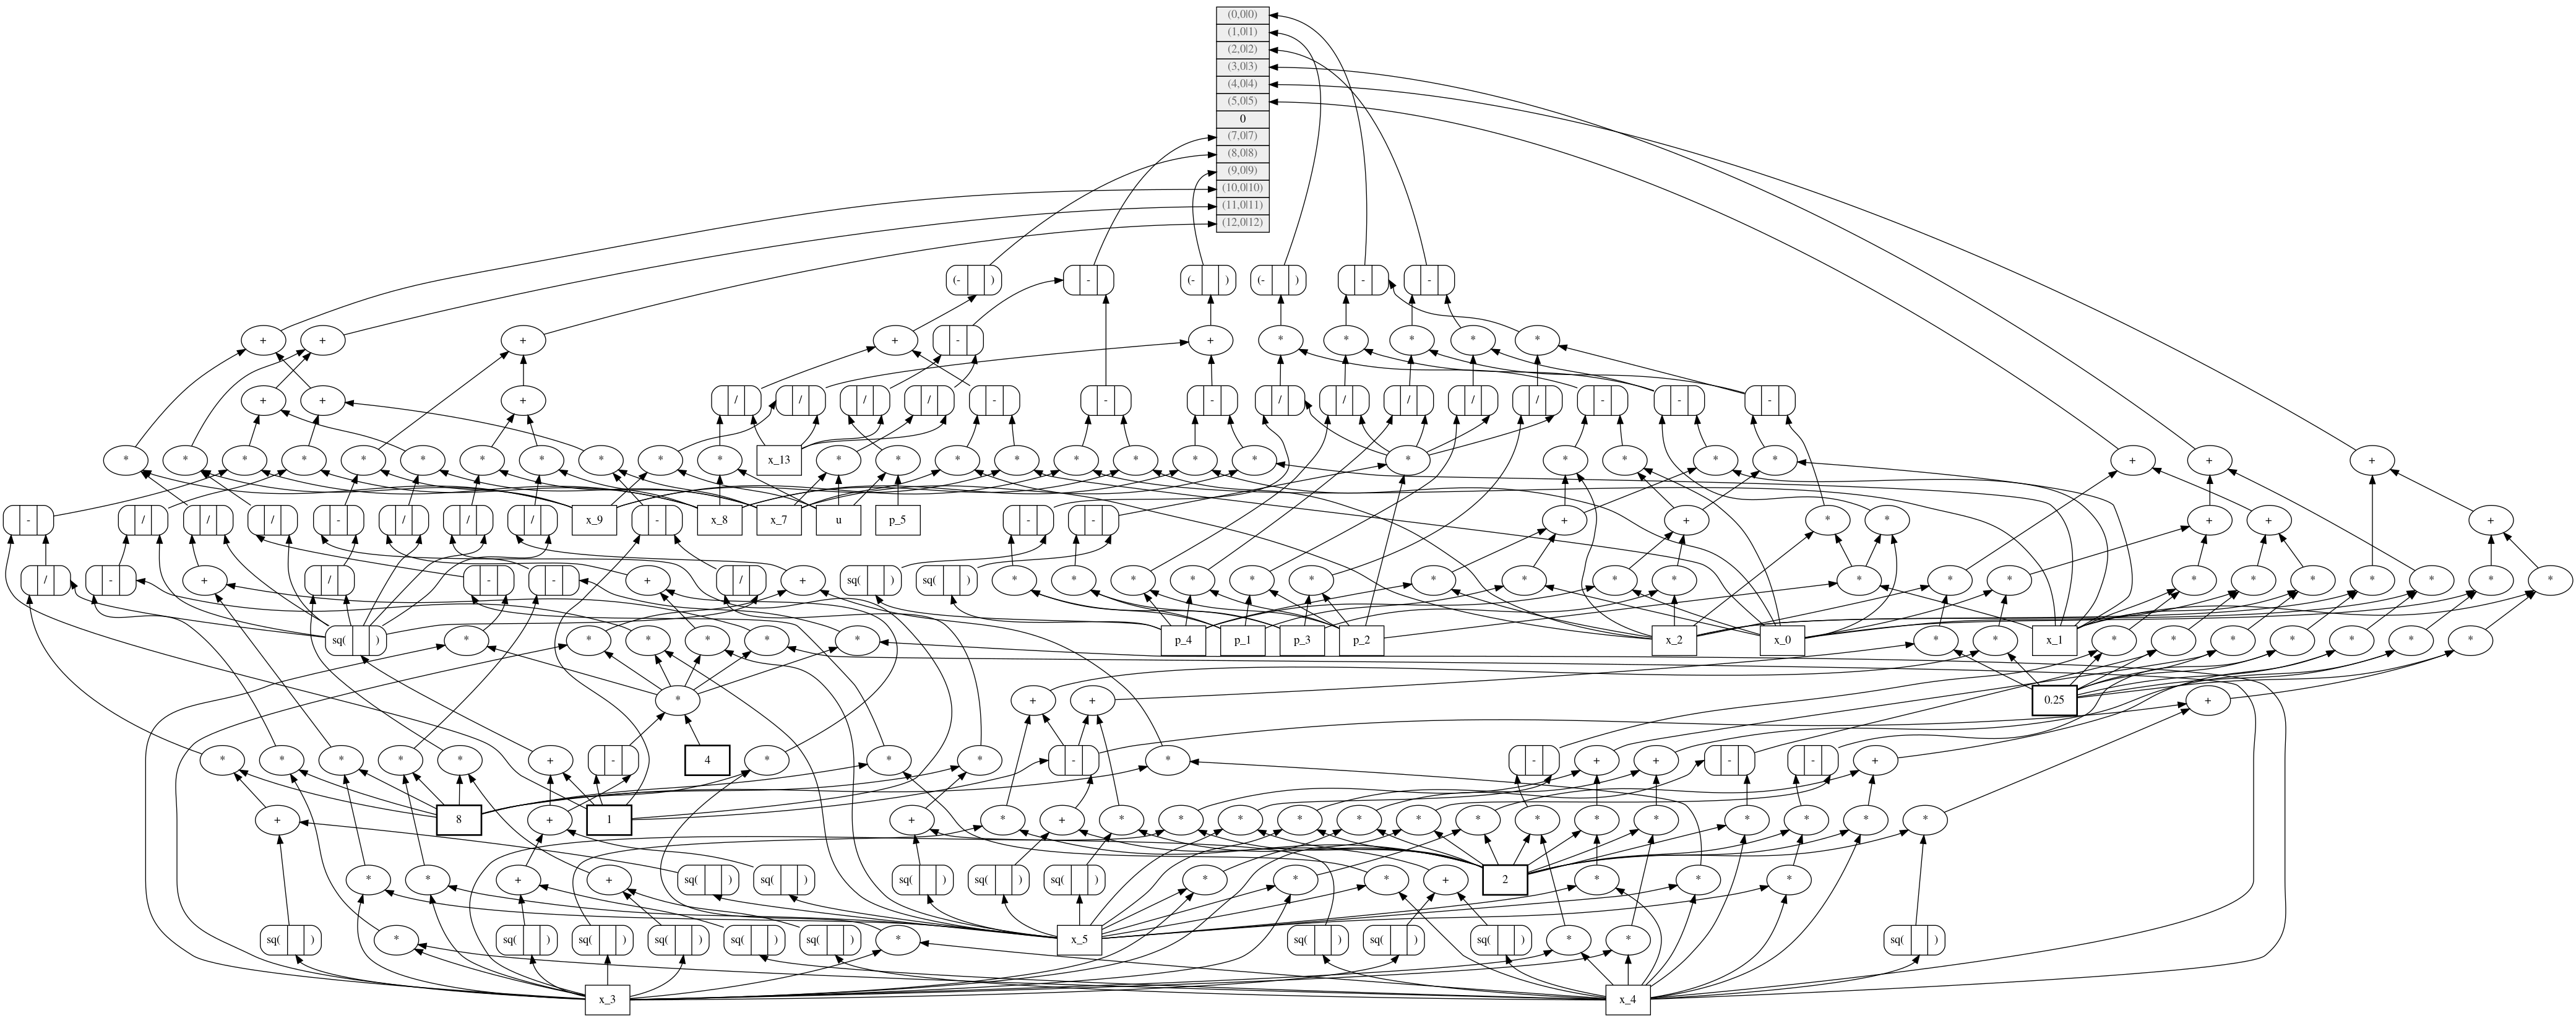

In [3]:
draw_graph(rhs(x, u, p))